# Homework 2 - balancing & binning (deadline 28. 11. 2020)

In short, the main task is to play with balancing and binning to obtain the best results for the binary classification task.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

## What are you supposed to do:

  1. Download the dataset [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
  1. Use 2 binning methods (on features of your choice, with your choice of parameters) and comment on its effects on classification performance.
  1. Use at least 2 other data balancing techniques of your choice on the dataset and comment the classification results. **Just copied code from tutorial 4 will not be accepted.**
  1. Run all classification tests at least three times - once for unbalanced original data, twice for balanced data (try at least 2 balancing techniques), compare those results (give a comment).
  
Give comments (!) on each step of your solution, with short explanations of your choices.

**If you do all this properly, you will obtain 16 points.** 

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.
  
## Data description

* The dataset can be downloaded [here](https://www.dropbox.com/s/aq08ytozfplb97b/data.csv?dl=0).
* The data are devoted to the binary classification task, the aim is to predict the probability that a driver will initiate an auto insurance claim in the next year.
* Target feature is called 'y' and signifies whether or not a claim was filed for that policy holder.
* To fulfill the task one does not need to know the meaning of predictors.
* Predictors that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation.
* While using [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), control the shuffling of data by random_state parameter. Do not use shuffle=False, probably never (can cause systematic error).

# Here comes my code

### Libraries Imports

In [65]:
import pandas as pd

from collections import namedtuple

import numpy as np
from numpy import where

from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
# Constants
SEED = 42

In [3]:
Dataset = namedtuple("Dataset", ["X", "y"])    

Model = namedtuple("Model", ["name", "classifier", "train_set", "test_set", "y_prediction"])

Evaluation = namedtuple("Evaluation", ["name", "model_name", "accuracy", "auc", "f1_score"])

Balancer = namedtuple("Balancer", ["name", "method"])

## 1) Download the dataset

In [4]:
# Load the Dataframe
original_df = data = pd.read_csv('data.csv')

df = original_df.copy()

In [5]:
# Basic information about the dataframe size, feature types etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 58 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   y             595212 non-null  int64  
 1   xind_01       595212 non-null  int64  
 2   xind_02_cat   595212 non-null  int64  
 3   xind_03       595212 non-null  int64  
 4   xind_04_cat   595212 non-null  int64  
 5   xind_05_cat   595212 non-null  int64  
 6   xind_06_bin   595212 non-null  int64  
 7   xind_07_bin   595212 non-null  int64  
 8   xind_08_bin   595212 non-null  int64  
 9   xind_09_bin   595212 non-null  int64  
 10  xind_10_bin   595212 non-null  int64  
 11  xind_11_bin   595212 non-null  int64  
 12  xind_12_bin   595212 non-null  int64  
 13  xind_13_bin   595212 non-null  int64  
 14  xind_14       595212 non-null  int64  
 15  xind_15       595212 non-null  int64  
 16  xind_16_bin   595212 non-null  int64  
 17  xind_17_bin   595212 non-null  int64  
 18  xind

In [6]:
# df.describe()

### Explore Missing Values

The missing values are encoded with value `-1` so it is not visible at first glance how much values there are missing.

In [7]:
# Create temporary missing_values dataframe for exploration purpose
mv = pd.DataFrame(df.apply(lambda x: (x == -1).sum()), columns=["missing_values"])

# Count the percentages
mv["percentage_missing"] = (mv["missing_values"] / df.shape[0]) * 100

display("Columns with missing values (-1) and percentage of values that are missing",
    mv[mv["missing_values"] != 0].sort_values("missing_values", ascending=False)
)

'Columns with missing values (-1) and percentage of values that are missing'

,missing_values,percentage_missing
xcar_03_cat,411231,69.089837
xcar_05_cat,266551,44.782531
xreg_03,107772,18.106490
xcar_14,42620,7.160474
xcar_07_cat,11489,1.930237
xind_05_cat,5809,0.975955
xcar_09_cat,569,0.095596
xind_02_cat,216,0.036290
xcar_01_cat,107,0.017977
xind_04_cat,83,0.013945


- The missing values should be treated separatedly.
    - Perhaps some imputation method should be used so the missing values would make sense.
    - Usually good choice is the k-Nearest Neighbors, however even the replacment with mean works better than just leaving there an artificial number.

- It does not need to be true, if the values are missing from some systematical reason, the reason can be explored.
    - For this analysis I will hope, the values are missing for a good reason, so I won't impute them anyhow.

## Copy Sample of the Dataframe

In [8]:
sample_df = original_df.sample(n=int(original_df.shape[0]/10), random_state=SEED).copy()

## Data Cleansing

- Convert Categorical Features to Categorical Type
- Check Type by the Column Name

In [9]:
def convertCategoricalFeatures(cols, df):
    """Convert given columns to types to categorical type.
    Show the categorical column types. Also show types of non-categorical features.
    """
    df[categorical_cols] = df[categorical_cols].astype("category")
    
    print(f"Categorical columns names and types\n{df[categorical_cols].dtypes}\n")
    print(f"Other columns types {df.drop(categorical_cols, axis=1).dtypes.unique()}")
    return df

In [10]:
# Columns with "_cat" suffix should be treated as cetegorical
categorical_cols = [x for x in sample_df.columns if x.endswith("_cat")]

sample_df = convertCategoricalFeatures(categorical_cols, sample_df)

Categorical columns names and types
xind_02_cat    category
xind_04_cat    category
xind_05_cat    category
xcar_01_cat    category
xcar_02_cat    category
xcar_03_cat    category
xcar_04_cat    category
xcar_05_cat    category
xcar_06_cat    category
xcar_07_cat    category
xcar_08_cat    category
xcar_09_cat    category
xcar_10_cat    category
xcar_11_cat    category
dtype: object

Other columns types [dtype('int64') dtype('float64')]


### Make Categorical Columns Suitable for Classifiers

- Check if One-Hot encoding is possible (i.e. check whether the cardinality is not to high)

In [11]:
df = sample_df

uv = pd.DataFrame(df[categorical_cols].nunique(), columns=["unique_values"]) #.value_counts()

display(uv)

,unique_values
xind_02_cat,5
xind_04_cat,3
xind_05_cat,8
xcar_01_cat,13
xcar_02_cat,2
xcar_03_cat,3
xcar_04_cat,10
xcar_05_cat,3
xcar_06_cat,18
xcar_07_cat,3


### Some columns has high cardinality let's look how much values are they miss

- In case there would be significant percentage of missing values we could drop them with peace in mind
    - I'm not sure, this cardinality increase is worth one column of features

In [12]:
df = sample_df

high_card_rows = uv[uv["unique_values"] >= 5].index

mv.loc[high_card_rows, :]

,missing_values,percentage_missing
xind_02_cat,216,0.036290
xind_05_cat,5809,0.975955
xcar_01_cat,107,0.017977
xcar_04_cat,0,0.000000
xcar_06_cat,0,0.000000
xcar_09_cat,569,0.095596
xcar_11_cat,0,0.000000


In [13]:
def showHistogramAndBoxplot(feature, df):
    """Show histogram and boxplot for given dataframe feature"""
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 6)
    sns.distplot(df[feature], kde=False, ax=axes[0]).set_title(f"Histogram of {feature} feature")
    sns.boxplot(df[feature], ax=axes[1]).set_title(f"{feature} feature boxplot")

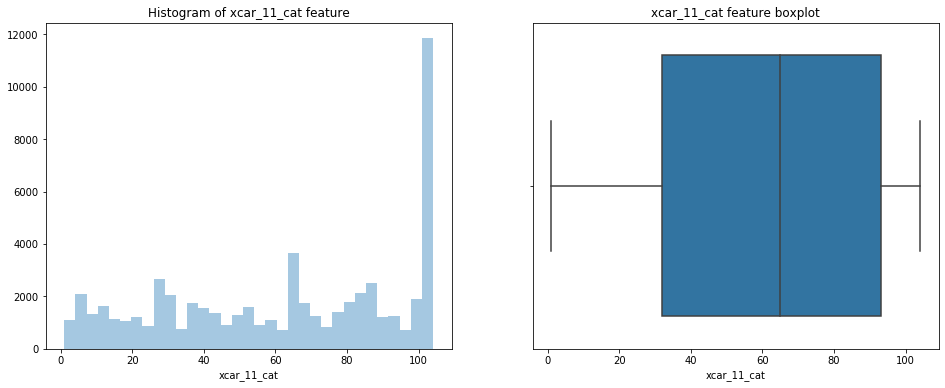

In [14]:
showHistogramAndBoxplot("xcar_11_cat", sample_df)

### One-hot Encoding

- Concatenate non-categorical columns with the one-hot encoding of the categorical colums.

In [15]:
def oneHotEncoding(cols, df):
    """For given columns perform one-hot encoding.
    Add the encoded columns to the given dataframe and drop the original (not-encoded) columns.
    """
    df = pd.concat([
        df.drop(cols, axis=1), 
        pd.get_dummies(df[cols])
    ], axis=1)
    print(f"Number of columns after encoding: {df.shape[1]}")
    return df

sample_df = oneHotEncoding(categorical_cols, sample_df)

Number of columns after encoding: 227


In [16]:
df = sample_df

print("Encoded columns that represents missing values",
    *[x for x in df.columns if ("-1" in x)],
sep="\n")

Encoded columns that represents missing values
xind_02_cat_-1
xind_04_cat_-1
xind_05_cat_-1
xcar_01_cat_-1
xcar_03_cat_-1
xcar_05_cat_-1
xcar_07_cat_-1
xcar_09_cat_-1


## Binning

- I chosed to discretize the highest cardinality feature i.e. the fature with the biggest number of unique values.

In [17]:
binning_df = sample_df.copy()
df = binning_df

df.nunique().sort_values(ascending=False)[:10]

xcar_13     24216
xreg_03      4336
xcar_14       724
xcar_12       129
xcalc_10       24
xcalc_14       22
xreg_02        19
xcalc_11       19
xcar_15        15
xcalc_13       14
dtype: int64

The feature "xcar_13" has the biggest number of unique values by a lot so I will apply binning to it.

### Histogram of xcar_13 (values distribution)

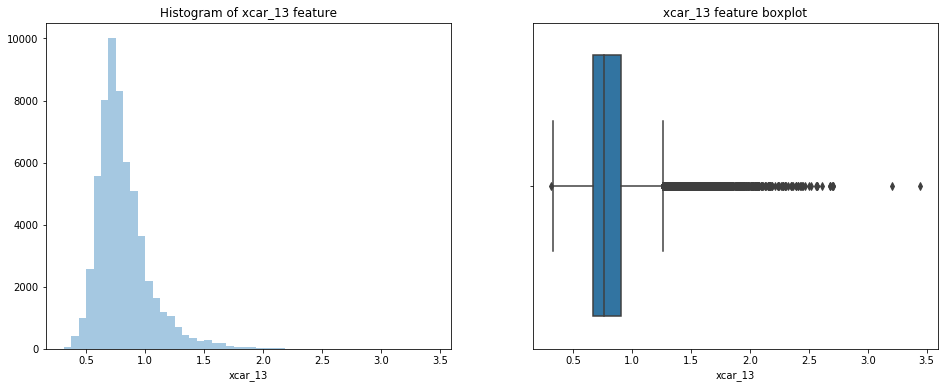

In [18]:
showHistogramAndBoxplot("xcar_13", binning_df)

Before I start with binning I will create a sample copy of the dataframe to do the test 

### Binning Function

In [19]:
def binFeatureEqualWidth(feature, df, equal="depth", interval_method=np.log2): # interval_method=np.sqrt
    interval_num = int(np.ceil(interval_method(df.xcar_13.nunique())))
    print(f"Number of Intervals: {interval_num}")

    bin_labels = list(range(interval_num))
    bin_feature = f"{feature}_{equal}_{interval_num}"
    print(f"Name of binned feature: {bin_feature}")
    
    bin_method = pd.qcut if equal == "depth" else pd.cut
    df[bin_feature] = bin_method(df[feature], interval_num, labels=bin_labels)
    return bin_feature


### Equal Width Binning

#### Number of bins

- As a rule of thumb i chosed to take square root of unique values rounded up.

Number of Intervals: 15
Name of binned feature: xcar_13_width_15


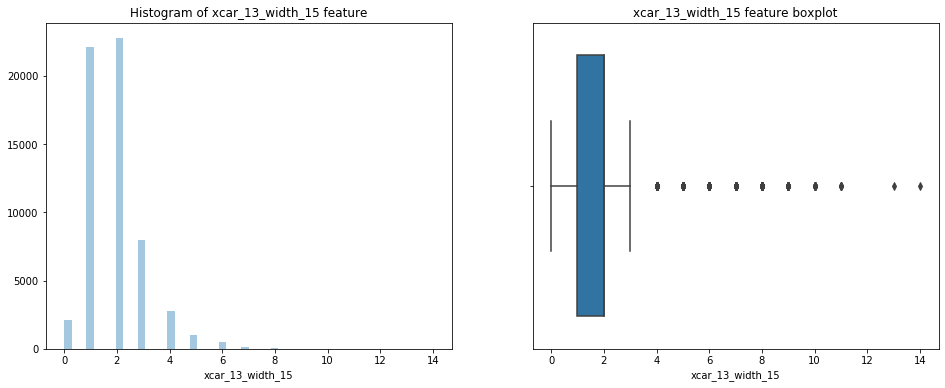

In [20]:
feature_width = binFeatureEqualWidth("xcar_13", binning_df, equal="width")
showHistogramAndBoxplot(feature_width, binning_df)

In [21]:
feature_width_sqrt = binFeatureEqualWidth("xcar_13", binning_df, equal="width", interval_method=np.sqrt)
# showHistogramAndBoxplot(feature_width_sqrt, binning_df)

Number of Intervals: 156
Name of binned feature: xcar_13_width_156


In [22]:
feature_width_log10 = binFeatureEqualWidth("xcar_13", binning_df, equal="width", interval_method=np.log10)
# showHistogramAndBoxplot(feature_width_log10, binning_df)

Number of Intervals: 5
Name of binned feature: xcar_13_width_5


### Equal Depth Binning

Number of Intervals: 15
Name of binned feature: xcar_13_depth_15


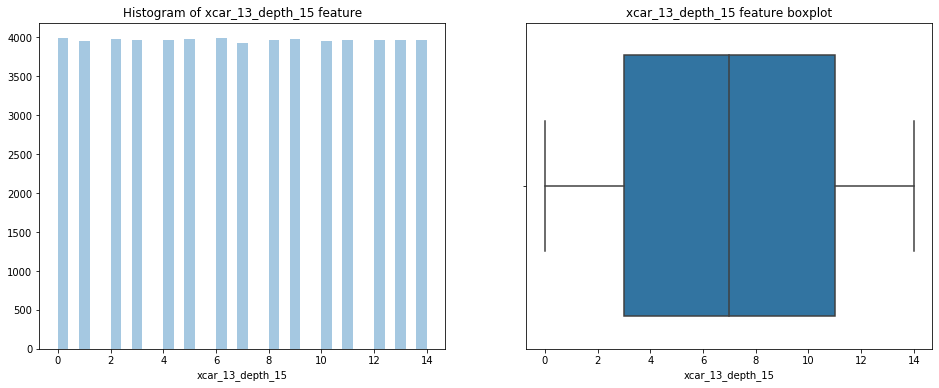

In [23]:
feature_depth = binFeatureEqualWidth("xcar_13", binning_df, equal="depth")
showHistogramAndBoxplot(feature_depth, binning_df)

In [24]:
feature_depth_sqrt = binFeatureEqualWidth("xcar_13", binning_df, equal="depth", interval_method=np.sqrt)
# showHistogramAndBoxplot(feature_depth_sqrt, binning_df)

Number of Intervals: 156
Name of binned feature: xcar_13_depth_156


In [25]:
feature_depth_log10 = binFeatureEqualWidth("xcar_13", binning_df, equal="depth", interval_method=np.log10)
# showHistogramAndBoxplot(feature_width_log10, binning_df)

Number of Intervals: 5
Name of binned feature: xcar_13_depth_5


In [26]:
def trainAndPredict(model_name, train_ds, test_ds):
    if model_name == "decision_tree":
        classifier = DecisionTreeClassifier(random_state=SEED)

    y_prediction =  classifier.fit(train_ds.X, train_ds.y).predict(test_ds.X)

    return Model(name=model_name, classifier=classifier, y_prediction=y_prediction,
        train_set=train_ds, test_set=test_ds) 


In [27]:
def trainWithAlternatingColumn(model_name, X_train, y_train, X_test, y_test, alternating_cols):
    """Return list of trained models. 
    The models are trained with X features, where is present only one column form alternating_cols at a time.
    """
    trained_models = {}
    for alt_col in alternating_cols:
        to_drop = [x for x in alternating_cols if x != alt_col]
        train_ds = Dataset(X_train.drop(to_drop, axis=1), y_train)
        test_ds = Dataset(X_test.drop(to_drop, axis=1), y_test)
        
        model = trainAndPredict(model_name, train_ds, test_ds)
        
        print(f"Train Set and Test Set Sizes [{alt_col}] (rows, columns)\n",
            f"Train set: X={train_ds.X.shape}, y={train_ds.y.shape}",
            f"| Test set:  X={test_ds.X.shape}, y={test_ds.y.shape}\n")
        
        trained_models[alt_col] = model
    
    return trained_models


In [28]:
df = binning_df

alternating_cols = [x for x in df.columns if (("_width" in x) or ("_depth" in x))]
alternating_cols.append(alternating_cols[0].split("_width")[0].split("_depth")[0])
# display(alternating_cols)

ds = Dataset(df.drop("y", axis=1), df.y)
X_train, X_test, y_train, y_test = train_test_split(ds.X, ds.y, test_size=0.33, random_state=SEED)

trained_models = trainWithAlternatingColumn("decision_tree", alternating_cols=alternating_cols,
    X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Train Set and Test Set Sizes [xcar_13_width_15] (rows, columns)
 Train set: X=(39879, 226), y=(39879,) | Test set:  X=(19642, 226), y=(19642,)

Train Set and Test Set Sizes [xcar_13_width_156] (rows, columns)
 Train set: X=(39879, 226), y=(39879,) | Test set:  X=(19642, 226), y=(19642,)

Train Set and Test Set Sizes [xcar_13_width_5] (rows, columns)
 Train set: X=(39879, 226), y=(39879,) | Test set:  X=(19642, 226), y=(19642,)

Train Set and Test Set Sizes [xcar_13_depth_15] (rows, columns)
 Train set: X=(39879, 226), y=(39879,) | Test set:  X=(19642, 226), y=(19642,)

Train Set and Test Set Sizes [xcar_13_depth_156] (rows, columns)
 Train set: X=(39879, 226), y=(39879,) | Test set:  X=(19642, 226), y=(19642,)

Train Set and Test Set Sizes [xcar_13_depth_5] (rows, columns)
 Train set: X=(39879, 226), y=(39879,) | Test set:  X=(19642, 226), y=(19642,)

Train Set and Test Set Sizes [xcar_13] (rows, columns)
 Train set: X=(39879, 226), y=(39879,) | Test set:  X=(19642, 226), y=(19642,)



In [29]:
def evaluateModel(model, name):
    ev = Evaluation(name=name, model_name=model.name,
        accuracy=accuracy_score(model.test_set.y, model.y_prediction),
        auc=roc_auc_score(model.test_set.y, model.y_prediction),
        f1_score=f1_score(model.test_set.y, model.y_prediction))
    print(f"[{ev.model_name}] {ev.name}\n",
        f"Acc: {ev.accuracy:.5f}\tAUC: {ev.auc:.5f}\tF1: {ev.f1_score:.5f}\n")
    return ev

In [30]:
evals = []

for name, model in trained_models.items(): #, gnb_model, lr_model]: # 
    evals.append(evaluateModel(model, name))
    
# "Original Data Prediction Evaluation"

[decision_tree] xcar_13_width_15
 Acc: 0.92058	AUC: 0.50697	F1: 0.05340

[decision_tree] xcar_13_width_156
 Acc: 0.91885	AUC: 0.50607	F1: 0.05232

[decision_tree] xcar_13_width_5
 Acc: 0.91890	AUC: 0.49889	F1: 0.03978

[decision_tree] xcar_13_depth_15
 Acc: 0.92211	AUC: 0.50841	F1: 0.05556

[decision_tree] xcar_13_depth_156
 Acc: 0.91813	AUC: 0.50308	F1: 0.04739

[decision_tree] xcar_13_depth_5
 Acc: 0.91915	AUC: 0.49968	F1: 0.04106

[decision_tree] xcar_13
 Acc: 0.92053	AUC: 0.50432	F1: 0.04875



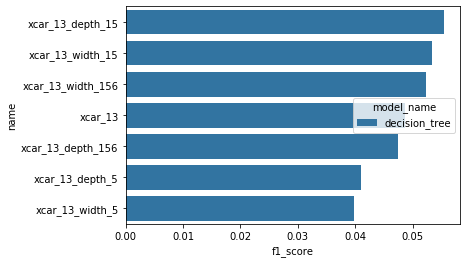

In [31]:
eval_df = pd.DataFrame(evals)

eval_df=eval_df.sort_values(by="f1_score", ascending=False)
sns.barplot(y="name", x="f1_score", hue="model_name", data=eval_df, orient="h")

## Balancing

In [33]:
balancing_df = sample_df.copy()

In [34]:
df.y.value_counts()

0    57310
1     2211
Name: y, dtype: int64

In [74]:
def trainWithBalancedSets(model_name, X_train, y_train, X_test, y_test, balancers):
    """Return list of trained models. 
    The models are trained with 
    """
    trained_models = {}
    
    test_ds = Dataset(X_test, y_test)
    
    for balancer in balancers:
#         print(f"X_train {X_train}, y_train {y_train}")
        train_ds = Dataset(*balancer.method.fit_sample(X_train, y_train))
        print(f"{balancer.name} train.X {train_ds.X.shape} | train.y {train_ds.y.shape} | {train_ds.y.value_counts()}")
        model = trainAndPredict(model_name, train_ds, test_ds)
        
        print(f"Train Set and Test Set Sizes [{balancer.name}] (rows, columns)",
            f"Train set: X={train_ds.X.shape}, y={train_ds.y.shape} | Test set:  X={test_ds.X.shape}, y={test_ds.y.shape}\n",
             sep="\n")
        
        trained_models[balancer.name] = model
    
    return trained_models


### Under-sampling

### Over-sampling methods

- Random Over-sampling
- SMOTE

In [75]:
balancers = [
    Balancer(name="random_over_sampling", method=RandomOverSampler(random_state=SEED)),
    Balancer(name="smote", method=SMOTE(random_state=SEED))
]

trainedAndBalanced = trainWithBalancedSets("decision_tree", X_train, y_train, X_test, y_test, balancers)


random_over_sampling train.X (76804, 226) | train.y (76804,) | 1    38402
0    38402
Name: y, dtype: int64
Train Set and Test Set Sizes [random_over_sampling] (rows, columns)
Train set: X=(76804, 226), y=(76804,) | Test set:  X=(19642, 226), y=(19642,)

smote train.X (76804, 226) | train.y (76804,) | 1    38402
0    38402
Name: y, dtype: int64
Train Set and Test Set Sizes [smote] (rows, columns)
Train set: X=(76804, 226), y=(76804,) | Test set:  X=(19642, 226), y=(19642,)



In [76]:
balancing_evals = []

for name, model in trainedAndBalanced.items(): #, gnb_model, lr_model]: # 
    balancing_evals.append(evaluateModel(model, name))


[decision_tree] random_over_sampling
 Acc: 0.91900	AUC: 0.49960	F1: 0.04099

[decision_tree] smote
 Acc: 0.91589	AUC: 0.50519	F1: 0.05166



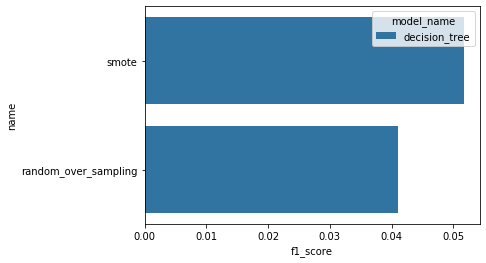

In [78]:
bal_eval_df = pd.DataFrame(balancing_evals)

bal_eval_df=bal_eval_df.sort_values(by="f1_score", ascending=False)
sns.barplot(y="name", x="f1_score", hue="model_name", data=bal_eval_df, orient="h")

## Classification Tests and Evalutaions

### Divide the dataset into train set and test set

In [66]:
df = sample_df

ds = Dataset(df.drop("y", axis=1), df.y)

X_train, X_test, y_train, y_test = train_test_split(ds.X, ds.y, test_size=0.33, random_state=SEED)
train_ds, test_ds = Dataset(X_train, y_train), Dataset(X_test, y_test)

In [76]:
print(f"""Train Set and Test Set Sizes (rows, columns)
Train set: X={train_ds.X.shape}, y={train_ds.y.shape}
Test set:  X={test_ds.X.shape}, y={test_ds.y.shape}
""")


Train Set and Test Set Sizes (rows, columns)
Train set: X=(39879, 226), y=(39879,)
Test set:  X=(19642, 226), y=(19642,)



### Classifiers and Predictions

### k-Means (2)

In [48]:
# %%time

# km = KMeans(n_clusters=2, random_state=SEED)

# y_pred_km = km.fit(train_ds.X, train_ds.y).predict(test_ds.X)

# # Structure the data together
# km_model = Model(name="k_means", classifier=km, 
#     train_set=train_ds, test_set=test_ds, y_prediction=y_pred_km
# ) 

### Logistic Regression

In [56]:
%%time

lr = LogisticRegression(max_iter=1000, random_state=SEED)
y_pred_lr = lr.fit(train_ds.X, train_ds.y).predict(test_ds.X)

# Structure the data together
lr_model = Model(name="logistic_regression", classifier=lr, 
    train_set=train_ds, test_set=test_ds, y_prediction=y_pred_lr
) 

CPU times: user 19min 50s, sys: 8min 13s, total: 28min 4s
Wall time: 3min 44s


### Decision Tree Learning and Prediciton

In [32]:
%%time

dtc = DecisionTreeClassifier(random_state=SEED)
y_pred_dtc = dtc.fit(train_ds.X, train_ds.y).predict(test_ds.X)

dtc_model = Model(name="decision_tree", classifier=dtc, y_prediction=y_pred_dtc,
    train_set=train_ds, test_set=test_ds) 

NameError: name 'train_ds' is not defined

### Naive Bayes

In [52]:
%%time

gnb = GaussianNB()
y_pred_gnb = gnb.fit(train_ds.X, train_ds.y).predict(test_ds.X)

gnb_model = Model(name="naive_bayes", classifier=gnb, y_prediction=y_pred_gnb,
    train_set=train_ds, test_set=test_ds) 

CPU times: user 1.35 s, sys: 17 s, total: 18.4 s
Wall time: 18.5 s


In [ ]:
### 

### Prediction Evaluation and Comparison

In [90]:
evals = []

for model in [dtc_model]: #, gnb_model, lr_model]: # 
    evals.append(evaluateModel(model, "Original Data Prediction Evaluation"))

Original Data Prediction Evaluation [decision_tree]
Accuracy: 0.9191019244476123
AUC:      0.5040208288748973
F1-score: 0.04907241172950329



## IF THERE WILL BE TIME LEFT

In [ ]:
Dataset(y="b", X="a")

In [ ]:
# [x for x in zip(["x_train","x_test"], ["y_train","y_test"])]
a, b = zip(["x_train","x_test"], ["y_train","y_test"])
a, b

a, b = zip(train_test_split(df.drop('y', axis=1), test_size=0.33, random_state=SEED), ["y_train","y_test"])

ds = Dataset()

test_ds = train_test_split(X, y, test_size=0.33, random_state=SEED)
# df.drop('b', axis=1)


In [ ]:
print("stopped?")

In [88]:
id(main_df) == id(df)

True

In [ ]:
# sample_df = sample_df.drop(alternating_cols, axis=1)